# Topic Modelling of UK Parliamentary Speeches Using Spark

#### Abstract
The goal of this project is to investigate the use of Spark machine learning algorithms to perform clustering and topic modelling of a new gathered dataset containing speeches by Members of Parliament of the UK House of Commons over the course of the past year. The aim is to determine the best approach for modelling this data and how to best harness the distributed computing power of Spark to do this with computational efficiency. This text data is very high-dimensional so the algorithms can become computationally expensive without an efficient approach. I will also discuss validating the topic model and visualizing the results. 

## Table of Contents

1. Introduction
2. The Data
3. Computing Set-up
4. Summary of Data
5. Modelling
6. Computational Efficiency
7. Conclusion
8. References

## 1. Introduction

### Apache Spark
Apache Spark is a unified analytics engine for large-scale distributed data processing. It was designed by researchers at UC Berkeley beginning in 2009 in an effort to improve the existing MapReduce technology. They were aimiming to make it both more efficient for interactive for iterative computing jobs, as well as to make it a less difficult system to learn. Spark provides in-memory storage for intermediate computations, making it much faster than Hadoop MapReduce. It incorporates libraries with composable APIs for machine learning (MLlib), SQL for interactive queries (Spark SQL), stream processing (Structured Streaming) for interacting with real-time data, and graph processing (GraphX). In this paper I will be making use of Resilient Distributed Datasets (below), Spark DataFrames, the Spark SQL API and I will be relying on MLlib implementation of machine learning algorithms to build a Latent Dirichlet Allocation (LDA) topic model. 

### Resilient Distributed Datasets (RDDs) and DataFrames
An RDD is an immutable distributed collection of elements of data, partitioned across nodes in a cluster that can be operated in parallel with a low-level API that offers transformations and actions. RDDs are extremely useful in many of the processing steps of this paper and Spark makes it very easy to move your data between RDDs and DataFrames, with simple API method calls, depending on which format better suits your needs. 

In general, I will be using RDDs in the processing steps when I need to do iterative operations on the data in a distributed way and I do not need the structure of a DataFrame. I will then transition to using DataFrames, which allows me to impose structure onto the data including useful functionality like column names. 


### Topic Modelling Background
Topic models offer an automated procedure for discovering the main "themes" in an unstructured corpus of texts. This is a form of unsupervised machine learning because the topic model requires no labelled data. The model determines themes from a set of documents using a probabilistic model based on word frequencies and creates document clusters based on the breakdown of the themes within the documents. 

The topic model I will be using is called a Latent Dirichlet Allocation. This is a "mixture model" meaning that documents can contain multiple topics and words can belong to multiple topics. 

#### Latent Dirichlet Allocation

<img src="Image/lda.png" style="width: 700px;">

From: Probabilistic topic models, David Blei, 2012.


The Latent Dirichlet Allocation topic model assumes a statistical model that generated the observed corpus and then estimates the model in order to recover latent topics under the assumptions made. Each document is assumed to contain weights of topics and each topic is assumed to contain weights of words. 

The Latent Dirichlet Allocation makes use of a probability distribution called the Dirichlet distribution. 

#### Dirichlet distribution: probability distribution over a simplex

<img src="Image/dirichlet.png" style="width: 700px;">

From: Wikipedia.

The LDA model assumes that the documents have been generated using a generative model. For each document its topic shares are drawn from a Dirichlet distribution to determine the topic distributions for the given topic. Then it is possible to draw word shares from a second Dirichlet distribution for each of the topics in the document. Finally, the model fills in each document with words by drawing a topic from the given document's multinomial topic distribution and drawing a word by taking a draw from the corresponding multinomial topic distribution. Of course, this is not how Parliamentary speeches (or any documents written by humans) are actually written, but assuming that this is how they are generated allows us to back out the shares of topics within documents and the shares of words within topics.

These successive draws can also be visualized using plate notation as in Blei, 2012. In the diagram below $\alpha$ represents the topic distribution and $\eta$ represents the word distributions. 

#### Plate Notation

<img src="Image/plate_notation.png" style="width: 700px;">

From: Probabilistic topic models, David Blei, 2012.

Estimating the topic model is done in a Bayesian framework. The two Dirichlet distributions from which we have drawn our topic shares and our word shares are the prior distributions. Using Bayes' rule, and our actual text data, we can update the prior distributions to obtain new posterior distributions of the topics and words. Once we have these distributions we can form clusters by grouping documents together based on their similarities in terms of topic distribution. These clusters are the objective of this kind of model and of this paper.


## 2. The Data

### Source 

The website theyworkforyou.com keeps a record of all Parliamentary speeches going back many years in what are called [Hansard Reports](https://parser.theyworkforyou.com/hansard.html). The website allows you to query the data in the form of raw XML files using "rsync". In order to download all speeches from 2020-2021 I used the following command.

     rsync -az --progress --exclude '.svn' --exclude 'tmp/' --relative data.theyworkforyou.com::parldata/scrapedxml/debates/debates202* .

### Cleaning and pre-pre-processing

These files require a fair amount of processing before they are in a usable format. I found a very useful project that maintains R scripts to clean and process these XML files. [The code is all available on GitHub](https://github.com/evanodell/hansard-data). 

The R scripts, which I have modified for the spficics of the data, are saved in this repository. There are 4 important files. "01_process_data.R" does the initial processing and transfers the data from XML format to an R dataframe and outputs an RDS data file. "02_member_matching.R" handles the names of the MPs using their member ids. "03_combining.R" combines the intermediate data files into one, and "04_final_cleaning.R" does some final formatting of the dataset before outputting the the final RDS or csv file. Please have a look at these R scripts for more information on this step.

## 3. Computing Setup

In this paper I make use of a few different computing setups. First, I installed PySpark on my local machine so that I could test functionality locally before moving it to a Google Cloud Platform cluster. This proved helpful because otherwise it is possible to use up GCP credit really quickly before the code is working properly. I tested the code on my local machine and then moved it to GCP clusters in order to speed up the processes and not rely on my own computing power. The data is very high-dimensional because it is text data so it was infeasible to run all of the modelling locally.

To make use of a GCP cluster I had to follow a couple steps. First, I needed to create a bucket and upload the data to the bucket. This was time consuming because of the size of the data. 

    gsutil cp C:\<path_to_file> gs://<bucket_name>

Second, I created a Dataproc Cluster. See documentation on Dataproc clusters [here](https://cloud.google.com/dataproc/docs/). I created a few different clusters in order to experiment with the optimal number of worker nodes. In the below exmaple I created a cluster with 2 worker nodes. See the Computational Efficiency section below for more information on experimenting with different numbers of worker nodes.

    gcloud beta dataproc clusters create capstone-cluster --project covid-political-speech \
        --bucket maxdk-capstone-bucket --region europe-west2 \
        --num-workers 2 \
        --image-version=1.4-debian10 \
        --optional-components=ANACONDA,JUPYTER \
        --enable-component-gateway \
        --initialization-actions \
        gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,gs://maxdk-capstone-bucket/my-actions.sh \
        --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy'
        
Third, using the cluster I opened a console window and downloaded the data from the bucket.

    gsutil cp gs://<bucket_name>/<path_to_file> .

Fourth, I put the datafile into the Hadoop Distributed File System (HDFS) in order to make it easily accessible from a Jupyter notebook. 

    hadoop fs -put ./ /covid_speeches.csv
    
Finally, I created a Jupyter notebook and began the analysis you'll see below.


## 4. Cleaing & Pre-processing

Creating a topic model requires constructing a term-frequency matrix from the text data. This process reduces each document to a row in a matrix whose columns are terms (words) and each cell is the frequency with which that feature occurs in the document. In this case each document is a Parliamentary speech.  

The first step is to generate tokens from the text. This involves breaking the text up into lists of features, which are either words or sometimes bi-grams (two words) or tri-grams (three words). In this step I also process and standardize the text data in a few ways. For instance, I convert the features to lower case and remove punctuation. I also use a process called [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) to get the roots of the words. In this stage I convert the original speeches dataframe into an RDD to help with efficient processing. 


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Opps').getOrCreate()
#import nltk
#nltk.download('all')

In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

# The lemmatizer incorrectly deals with the below words.
# It trims the last "s" off so I have added them to a list of tokens to not lemmatize
no_lemmatize = ["nhs", "wales"]

# this line gets the data from hdfs. It is possible because of the 4th step in the computing setup above.
speeches_path = "hdfs:///covid_speeches.csv" 
speeches_df = spark.read.csv(speeches_path, 
                    header='true', sep=',')

def get_tokens(line):
    ###
    import nltk
    #nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove stopwords
    # remove punctuation from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words
    words = [lmtzr.lemmatize(w) for w in words if not w in no_lemmatize]
    return (words)

# create an rdd and apply the get_tokens function to each document
speeches_rdd = speeches_df.rdd.map(tuple)
speeches_rdd = speeches_rdd.map(lambda line: (1, get_tokens(line[0])))

[(1,
  ['behalf',
   'whole',
   'house',
   'wish',
   'express',
   'deepest',
   'sympathy',
   'people',
   'australia',
   'continue',
   'experience',
   'horrific',
   'wildfire',
   'laying',
   'waste',
   'much',
   'send',
   'message',
   'solidarity',
   'commonwealth',
   'colleague',
   'australian',
   'parliament',
   'pay',
   'tribute',
   'firefighter',
   'putting',
   'life',
   'riskthe',
   'magnitude',
   'disaster',
   'unfolding',
   'australia',
   'shock',
   'u',
   'human',
   'animal',
   'life',
   'precious',
   'specie',
   'fauna',
   'destroyed',
   'wakeup',
   'call',
   'world',
   'australian',
   'thought',
   'prayer',
   'rang',
   'speaker',
   'australian',
   'house',
   'representative',
   'five',
   'day',
   'ago',
   'express',
   'worry',
   'concern',
   'oral',
   'statement',
   'thursday',
   'member',
   'wish',
   'speak',
   'matter',
   'able',
   'theni',
   'draw',
   'member',
   'attention',
   'fact',
   'book',
   'ente

In [40]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# create a spark dataframe and add a row_index column
speeches_df=speeches_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

# these are the variables we have access to aside from the text data
speeches_df.show(3)

+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
|              speech|person_id|first_name|last_name|      date|       Party|     Constituency|row_index|
+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
|On behalf of the ...|    10295|   Lindsay|    Hoyle|2020-01-07|     Speaker|          Chorley|        1|
|Whether he plans ...|    25886|      Mark|    Logan|2020-01-07|Conservative|Bolton North East|        2|
|First, Mr Speaker...|    24854|     Sajid|    Javid|2020-01-07|Conservative|       Bromsgrove|        3|
+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
only showing top 3 rows



### Stopwords 

We have already removed a set of generic English language stopwords within the get_tokens function. However, I have found over the course of several runs through that adding some stopwords to that generic list for our specific purposes is helpful. For example, "hon" is a word found very frequently in these Parliamentary speeches because MPs refer to one another as "the right hon gentleman/lady." This word is not included in the list of stopwords used above and it doesn't add any particularly important meaning to the speech as it is a formality. Therefore it is worth removing. We can easily remove this word by excluding words that appear very frequently. In the code below I filter out words that appear more than 10,000 times throughout the corpus. This removes "hon" and a small number of other words that are used frequently in Parliamentary speeches but not considered stopwords in normal English. 

Additionally, the code below removes words that appear extremely infrequently - fewer than twice throughout the entire corpus. This is because the data has some typos. There are many examples of two words being concatenated with no space in between, which is a somewhat hairy problem to address so I have opted to simply remove those typos. Removing very rare words is a common step in text analysis as these words are unlikely to be important to the probabilistic model. Below we see some of these words which have been removed. 

In [4]:
# additionally filter out words that occur very frequently or very infrequently 
doc_stop_words = speeches_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
doc_stop_words = doc_stop_words.filter(lambda a: a[1]<2 or a[1]>10000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
speeches_rdd = speeches_rdd.map(lambda r: (r[0], [w for w in r[1] if not w in doc_stop_words and not len(w)==1]))

# view some of the stopwords we've removed
# many of them are typos that would not contribute to the model
doc_stop_words[50:59]

['lawmost',
 'accordinglythat',
 'yearsnew',
 'keepwhen',
 'irelandon',
 'northwestturning',
 'banni',
 'antiunion',
 'inappropriatethe']

In [7]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

# create a dataframe for modelling
tokens_df = spark.createDataFrame(speeches_rdd, ["dummy","words"])
tokens_df.cache()
tokens_df.show(5)

+-----+--------------------+
|dummy|               words|
+-----+--------------------+
|    1|[behalf, whole, w...|
|    1|[whether, plan, i...|
|    1|[mr, speaker, ass...|
|    1|[election, campai...|
|    1|[remember, visit,...|
+-----+--------------------+
only showing top 5 rows



## 5. Modelling


In [27]:
# this is one of the steps I timed in order to experiment with different numbers of GCP nodes
#import timeit
#start_time = timeit.default_timer()

# create term-frequency matrix
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)
cv_model = cv.fit(tokens_df)

speeches_df_w_features = cv_model.transform(tokens_df)
speeches_df_w_features.cache()
speeches_df_w_features.show(5)
#elapsed = timeit.default_timer() - start_time
#print(elapsed)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[behalf, whole, w...|(40170,[14,17,22,...|
|    1|[whether, plan, i...|(40170,[46,53,55,...|
|    1|[mr, speaker, ass...|(40170,[29,37,55,...|
|    1|[election, campai...|(40170,[23,55,73,...|
|    1|[remember, visit,...|(40170,[8,23,37,4...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [11]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])
print("\n---\n")

W = len(cv_model.vocabulary)
print("Number of terms W = ", W)

Vocabulary from CountVectorizerModel is:
['like', 'thank', 'look', 'going', 'question', 'national', 'sector', 'system', 'number', 'working', 'sure', 'thing', 'course', 'area', 'day', 'prime', 'gentleman', 'world', 'measure', 'change', 'hope', 'deal', 'life', 'agree', 'welcome', 'trade', 'committee', 'give', 'clear', 'opportunity', 'able', 'family', 'council', 'future', 'including', 'forward', 'continue', 'every', 'done', 'constituent', 'pay', 'already', 'social', 'amendment', 'pandemic', 'month', 'plan', 'northern', 'even', 'end', 'given', 'great', 'ireland', 'set', 'whether', 'funding', 'absolutely', 'eu', 'economy', 'still', 'united', 'department', 'two', 'impact', 'scotland', 'law', 'review', 'parliament', 'power', 'report', 'matter', 'authority', 'billion', 'chancellor', 'international', 'decision', 'act', 'british', 'woman', 'mean', 'action', 'concern', 'money', 'crisis', 'order', 'policy', 'worker', 'however', 'taking', 'industry', 'risk', 'around', 'provide', 'lady', 'making', '

In [28]:
from pyspark.ml.clustering import LDA
# this is the second step I timed
#start_time2 = timeit.default_timer()

# set parameters of LDA model and fit data
lda = LDA(k=8, maxIter=7, optimizer='online', seed=4)
lda_model = lda.fit(speeches_df_w_features)

In [29]:
# two ways of measuring the likelihood of our data given our LDA model is using log likelihood and perplexity. 
# I used these two metrics to experiment with different model parameters

ll = lda_model.logLikelihood(speeches_df_w_features)

lp = lda_model.logPerplexity(speeches_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))
#elapsed_2 = timeit.default_timer() - start_time2
#print(elapsed_2)

The lower bound on the log likelihood of the entire corpus: -38825971.032892466
The upper bound on the perplexity: 8.419027683085684


In [30]:
# Describe topics
topics = lda_model.describeTopics(20)

print("The topics described by their top-weighted terms:")
topics.show()

# Below I print out the top words in each topic
import numpy as np
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics described by their top-weighted terms:
+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[78, 15, 18, 37, ...|[0.00401786159253...|
|    1|[6, 32, 55, 42, 1...|[0.00355062138291...|
|    2|[64, 11, 17, 16, ...|[0.00254543662537...|
|    3|[17, 6, 16, 36, 2...|[9.87347133558917...|
|    4|[103, 84, 95, 16,...|[0.00274249636086...|
|    5|[43, 25, 57, 119,...|[0.00553972347817...|
|    6|[11, 1, 6, 0, 41,...|[9.21051324176059...|
|    7|[7, 160, 8, 103, ...|[9.23446147101310...|
+-----+--------------------+--------------------+

['woman' 'prime' 'measure' 'every' 'national' 'decision' 'lockdown' 'like'
 'day' 'thank' 'virus' 'family' 'restriction' 'system' 'life'
 'international' 'month' 'going' 'welcome' 'number']
['sector' 'council' 'funding' 'social' 'tax' 'economy' 'billion' 'family'
 'system' 'chancellor' 'pay' 'area' 'crisis' 'fund' 'welcome' 'plan'
 'building' 'mea

### Interpreting the Topics

An important step of unsupervised topic modelling is interpreting the topics and making sure they coincide with human understanding of cohesive topics. The topics are only useful insofar as they describe actual topics humans would recognize. I experimented with different numbers of topics, different number of maxmimum iterations through the model, and between two different algorithm optimizers and ultimately found these topics to be most descriptive of the data. 


Of the topics above, the 0th and 7th appear to be largely about COVID-19, restrictions, vaccines, etc. In the 1th looks like many of the terms are related to the economy and perhaps a spending bill. The 2th topic has to do with Scotland and northern England among other things. The 4th topic appears to be largely about policing, law and order, and crime. The 5th topic appears to be about brexit including terms related to Ireland, Northern Ireland, and the new border. 

In [31]:
transformed = lda_model.transform(speeches_df_w_features)
transformed.show(3)

+-----+--------------------+--------------------+--------------------+
|dummy|               words|            features|   topicDistribution|
+-----+--------------------+--------------------+--------------------+
|    1|[behalf, whole, w...|(40170,[14,17,22,...|[8.59581364817453...|
|    1|[whether, plan, i...|(40170,[46,53,55,...|[0.01417611107083...|
|    1|[mr, speaker, ass...|(40170,[29,37,55,...|[0.00402913012389...|
+-----+--------------------+--------------------+--------------------+
only showing top 3 rows



In [32]:
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import lit
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# in this block I add a date column to the dataframe and divide the topic distribution arrays into their own columns 
# in order to analyze the distribution of topics over time

# create a spark dataframe and add a row_index column
speeches_df=speeches_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

# these are the variables we have access to aside from the text data
speeches_df.show(3)

# add date column to df
transformed = transformed.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
transformed_date = transformed.join(speeches_df, on=["row_index"]).drop("speech")

# expand topic distribution column into a column for each topic in vector
col_exploded = (transformed_date.withColumn("xs", vector_to_array("topicDistribution")).
                select(["date"] + ["Party"] + ["words"] + [col("xs")[i] for i in range(8)]))


+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
|              speech|person_id|first_name|last_name|      date|       Party|     Constituency|row_index|
+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
|On behalf of the ...|    10295|   Lindsay|    Hoyle|2020-01-07|     Speaker|          Chorley|        1|
|Whether he plans ...|    25886|      Mark|    Logan|2020-01-07|Conservative|Bolton North East|        2|
|First, Mr Speaker...|    24854|     Sajid|    Javid|2020-01-07|Conservative|       Bromsgrove|        3|
+--------------------+---------+----------+---------+----------+------------+-----------------+---------+
only showing top 3 rows



<AxesSubplot:xlabel='Date', ylabel='Mean Topic Distribution'>

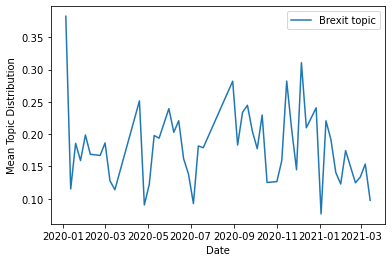

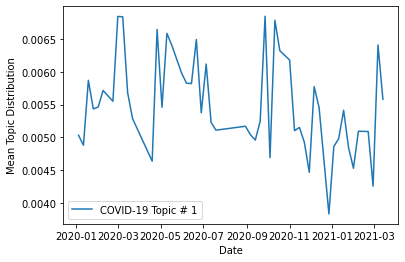

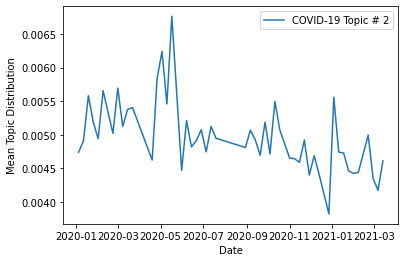

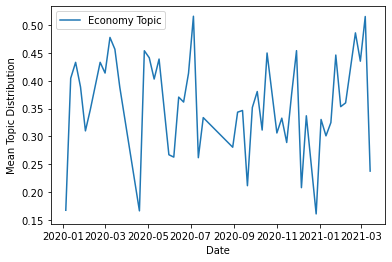

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyspark.sql.functions as f
import pandas as pd

# group by week and get mean of topic Distribution
time_df = (col_exploded.withColumn("week_strt_day", f.date_sub(f.next_day(col("date"),"sunday"),7))
                   .groupBy("week_strt_day")
                   .mean("xs[0]", "xs[1]", "xs[2]", "xs[3]", "xs[4]", "xs[5]", "xs[6]", "xs[7]"))

time_df = (time_df
       .filter(col("week_strt_day").isNotNull())
       .select(
        f.to_date("week_strt_day", "yyyy-mm-dd").alias("Date"),
        "avg(xs[0])",
        "avg(xs[1])",
        "avg(xs[2])",
        "avg(xs[3])",
        "avg(xs[4])",
        "avg(xs[5])",
        "avg(xs[6])",
        "avg(xs[7])")
       .orderBy("Date")
       .toPandas()
      )

# topic 5 is about the eu, northern ireland, and trade and we can see from this chart that it clearly peaks 
# in January 2020 which is when the Brexit agreement was signed including the Northern Ireland protocol. 

time_df.plot.line(x="Date", y="avg(xs[5])", label = "Brexit topic", ylabel = "Mean Topic Distribution")


# topics 0 and 7 on covid

time_df.plot.line(x="Date", y="avg(xs[0])", label = "COVID-19 Topic # 1", ylabel = "Mean Topic Distribution")

time_df.plot.line(x="Date", y="avg(xs[7])", label = "COVID-19 Topic # 2", ylabel = "Mean Topic Distribution")


# topic 1 is on the economy and government spending. There is a peak in March 2021 when 
# Chancellor of the Exchequer Rishi Sunak announced major changes to the COVID spending
# See: https://www.twobirds.com/en/news/articles/2020/uk/uk-government-financial-package-for-covid-19-relief. 

time_df.plot.line(x="Date", y="avg(xs[1])", label = "Economy Topic", ylabel = "Mean Topic Distribution")

<AxesSubplot:xlabel='Party', ylabel='Mean Topic Distribution'>

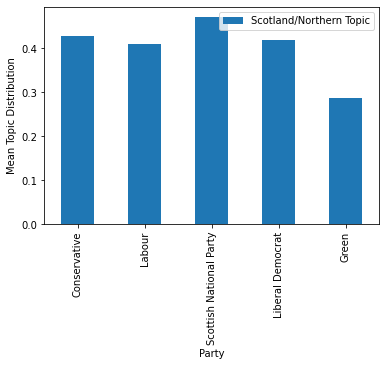

In [53]:
# group rows by Party to get averages of topic distributions within Parties

main_party_list = ['Conservative', 'Labour', 'Scottish National Party', 'Liberal Democrat', 'Green']


party_df = (col_exploded.groupBy("Party")
            .mean("xs[0]", "xs[1]", "xs[2]", "xs[3]", "xs[4]", "xs[5]", "xs[6]", "xs[7]")
            .filter(col("Party").isin(main_party_list))
            .toPandas())

# compare parties in terms of how much they talk about the Scotland/Northern England topic. As we would expect,
# the Scottish National Party speaks most about this topic according to the model. 
party_df.plot.bar(x="Party", y="avg(xs[2])", label = "Scotland/Northern England Topic", ylabel = "Mean Topic Distribution")

## 6. Computational Efficiency

Here I set out to answer a few questions about optimizing computational efficiency for LDA topic model building. The first question is in regards to which algorithm optimizer is most efficient. Spark offers an "Online" version of the LDA model training. This is a modification of the version of the algorithm we have run above. The Online variational Bayes LDA algorithm processes a subset of the corpus during each iteration, and updates the term-topic distribution adaptively. This suggests that it may improve computational efficiency because with each iteration the algorithm is building on the previous term-topic distribution. We can assess the extent to which this is true by training the model repeatedly with different sample sizes and plotting the results as we do below.


In [35]:
train, test = speeches_df_w_features.randomSplit([9.0, 1.0], 24)

import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

def measure_speed(lda, train, test, stage):
    testPerplexity = np.zeros(stage)
    computationTime = np.zeros(stage)
    fracs = np.linspace(0.1, 1.0, stage)
    num_repeat = 5
    for j in range(num_repeat):
        for i in range(stage):
            corpus = train.sample(False, fracs[i], 10*j)
            # Batch variational inference
            t0 = time()
            lda_model = lda.fit(corpus)
            t1 = time()
            computationTime[i] += (t1 - t0)/num_repeat
            testPerplexity[i] += lda_model.logPerplexity(test)/num_repeat
    return testPerplexity, computationTime

# set the seeds to have the same inital clustering
# batch LDA
test_perplexity_em, computation_time_em = measure_speed(LDA(k=8, maxIter=5, seed=123), 
                                                            train, test, 10)
# online LDA
test_perplexity_online, computation_time_online = measure_speed(LDA(k=8, maxIter=5, optimizer='online', seed=123), 
                                                                    train, test, 10)


### Expectation Maximisation vs Online LDA Algorithms

#### Computation time vs. training data size

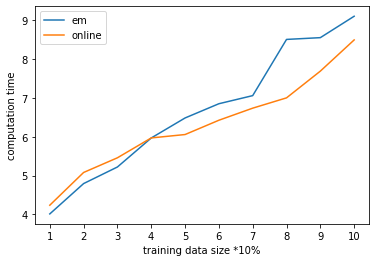

In [36]:
plt.plot(computation_time_em, label = "em")
plt.plot(computation_time_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("training data size *10%")
plt.ylabel("computation time")
plt.legend()
plt.show();

#### Testing perplexity vs. training data size

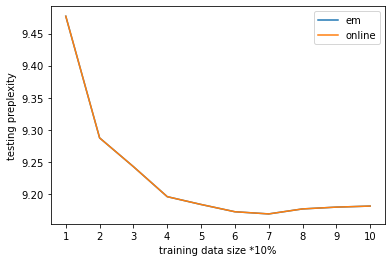

In [38]:
plt.plot(test_perplexity_em, label = "em")
plt.plot(test_perplexity_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("training data size *10%")
plt.ylabel("testing preplexity")
plt.legend()
plt.show();

The first plot compares the Online optimizer with the Expectation Maximisation algorithm. With larger training data it is more computationally efficient to use the Online optimizer. There is no apparent difference between the optimizing algorithms in terms of reducing testing perplexity. 

Testing perplexity is a measure of the strength of the model so it is instructive to consider how to most efficiently get to a strong model. Gvien the results of the two plots above it is possible to conclude that there is an advantage to using the Online optimizer because it reduces computational cost at larger training data sizes without sacrificing testing perplexity. 


### Number of Partitions

#### Computation time vs. number of partitions

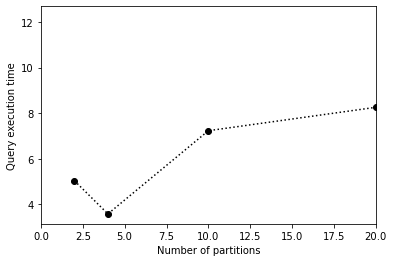

In [54]:
# number of partitions

train, test = speeches_df_w_features.randomSplit([9.0, 1.0], 24)

import numpy as np

# number of partitions to test
npart = [2,4,10,20,50]
stage = len(npart)
computationTime = np.zeros(stage)
fracs = np.linspace(0.1, 1.0, stage)

for i in range(0,len(npart)):
    train = train.repartition(npart[i]) # Repartition the RDDs
    test = test.repartition(npart[i])
    corpus = train.sample(False, fracs[i], 10)
    start_time = timeit.default_timer()
    lda = LDA(k=8, maxIter=5, optimizer='online', seed=4)
    lda_model = lda.fit(corpus)
    elapsed = timeit.default_timer() - start_time
    computationTime[i] = elapsed
    
# plotting the results
from matplotlib import pyplot as plt
%matplotlib inline

# Plot parameters
plt.plot(npart, computationTime, 'ko:') # Basic parameters
plt.xlabel("Number of partitions") # x-axis label
plt.ylabel("Query execution time") # y-axis label
plt.xlim([0,20]) # x-axis limits
#plt.ylim([12,14])
plt.show() # Show
    

## Number of worker nodes

I also analyzed how many worker nodes is most computationally efficient to run this analysis. There were two highly computationally expensive steps in this analysis. The first is the step which uses "CountVectorizer" to construct the term-frequency matrix. The second is when the LDA model is used to fit the data. To assess which number of worker nodes was optimal I ran those two steps and timed them with three different numbers of worker nodes. The chart below shows the results.

<img src="Image/nodes.png" style="width: 700px;">

Interestingly, no single cluster setup was consistently highest performing across both of these steps, which indicates that different numbers of clusters should be used for different kinds of analysis when possible. However, considering both steps together, a GCP cluster with 2 worker nodes appears to be most computationally efficient. 

It is tempting to think that the more worker nodes a cluster has, the more computing power it has, and therefore the faster it will do computations. However, there can be a cost of adding unneccessary worker nodes and that appears to be the case with the third worker node in this case. 


## 7. Conclusion

In this paper I have sought to demonstrate the use of distributed computing with Spark to perform unsupervised machine learning on a corpus of Parliamentary speeches data. I used a Spark implementation of the LDA topic model algorithm to model this corpus and analyzed the results. I also explored ways of improving computational efficiency with different number of partitions of RDDs and using different numbers of GCP clusters to perform the most computationall expensive steps. I believe Spark is a very useful tool for this kind of analysis because it is significantly faster than running these large operations on one machine and the APIs make the use of functionality like machine learning algorithms straightforward. 

And important step of topic modelling is validation of the model. I have tried to validate the topic model in a number of ways: by studying the top-weighted words in each topic in order to assess coherence of the topic, by assessing the log likelihood and perplexity of the model as it relates to some held-out documents, by analyzing the distribution of topics over time, and by comparing the topics to political party of the speaker. For the most part the results coincide with my intuitive understanding of the topics. Using both these validation techniques as well as my own judgement of what a coherent topic looks like I ended up using a value of K=7 for the number of topics in the data. 

Next steps could include exploring other topic model algorithms like Correlated topic models (CTM) as in Blei and Lafferty (2005, 2007) which swaps the Dirichlet distribution of topic shares in documents with a logistic normal distribution. Roberts et al. (2013) have also used a Structural topic model (STM) which allows topic proportions within documents to vary through covariates. 


## 8. References

[1] Apache Spark: Machine Learning Library (MLlib) Guide. [https://spark.apache.org/docs/latest/ml-guide.html](https://spark.apache.org/docs/latest/ml-guide.html).

[2] Apache Spark: Latent Dirichlet Allocaiton (LDA). [https://spark.apache.org/docs/latest/ml-clustering.html#latent-dirichlet-allocation-lda](https://spark.apache.org/docs/latest/ml-clustering.html#latent-dirichlet-allocation-lda).

[3] Blei, D.M., A.Y. Ng and M.I. Jordan. 2003. “Latent dirichlet allocation.” The Journal of Machine Learning Research 3:993–1022.

[4] Blei, David M. 2012. “Probabilistic topic models.” Communications of the ACM 55(4):77. [doi: 10.1145/2133806.2133826](https://dl.acm.org/doi/10.1145/2133806.2133826).

[5] Blei, David, and John Lafferty. "Correlated topic models." Advances in neural information processing systems 18 (2006): 147.

[6] MySociety. Hansard Reports. [https://parser.theyworkforyou.com/hansard.html](https://parser.theyworkforyou.com/hansard.html).

[7] Odell, Evan. 2020. "Hansard Speeches Version 3." [https://github.com/evanodell/hansard-data3](https://github.com/evanodell/hansard-data3).

[8] Roberts, Margaret E., et al. "The structural topic model and applied social science." Advances in neural information processing systems workshop on topic models: computation, application, and evaluation. Vol. 4. 2013.

[9] Zaharia, M., Chowdhury, M., Das, T., Dave, A., Ma, J., McCauley, M., ... & Stoica, I. (2012, April). Resilient distributed datasets: A fault-tolerant abstraction for in-memory cluster computing. In Proceedings of the 9th USENIX conference on Networked Systems Design and Implementation (pp. 2-2). USENIX Association.